In [4]:
%reload_ext watermark
%watermark -v -p pandas,matplotlib,seaborn,google_play_scraper

Python implementation: CPython
Python version       : 3.7.14
IPython version      : 7.9.0

pandas             : 1.3.5
matplotlib         : 3.2.2
seaborn            : 0.11.2
google_play_scraper: not installed



# Import libraries

In [7]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
font_size_=12
# Import
from copy import deepcopy
# from bertopic import BERTopic

import json
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

# from google_play_scraper import Sort, reviews, app

from sortedcontainers import SortedDict

%matplotlib inline
plt.rcParams.update({'font.size': font_size_})
# sns.set(style="ticks")
# sns.set_theme()
# plt.rcParams['figure.figsize']=(15,10)
import dexplot as dxp


# Gather tweets

In [8]:
query = "tiago ev"
tweets = []
limit = 10000


for tweet in sntwitter.TwitterSearchScraper(query).get_items():
    
    # print(vars(tweet))
    # break
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.username, tweet.content])
        
reviews_df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])

# to save to csv
# reviews_df.to_csv('tweets.csv')

In [9]:
# reviews_df['Tweet'][0]
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9867 entries, 0 to 9866
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   Date    9867 non-null   datetime64[ns, UTC]
 1   User    9867 non-null   object             
 2   Tweet   9867 non-null   object             
dtypes: datetime64[ns, UTC](1), object(2)
memory usage: 231.4+ KB


# Data Cleaning

In [10]:
import re
import nltk
nltk.download('stopwords')
# from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

stopwords_list = ['car', 'app', 'tata', 'motors','tata motors', 'nexon', 'tata nexon', 'ira', 'zconnect', 'tatamotors', 'car', 
                  'suzuki','suzuki connect', 'hyundai', 'bluelink','blue link', 'mg', 'feature', 'update', 'mahindra', 'xuv', 'xuv700', 'adrenox',
                  'https', 'hector', 'work', 'working', 'Show', 'showing', 'even', 'now', 'vehicle', 'use', 'need', 'good', 'features',
                  'option', 'day', 'will','still','please','ev','blue','link',
                  'tiago','#tiagoev','o','-','hai','de','a','b','c','d','e']

# all_stopwords = stopwords.words('english')
# all_stopwords.remove('not')

# for item in stopwords_list:
#   all_stopwords.extend([item])

for item in stopwords_list:
  STOPWORDS.add(item)
  
reviews_df['content_clean']=''

# corpus = []
for i in range(0, reviews_df.shape[0]):
  
  review = reviews_df['Tweet'][i].lower()
#   review = re.sub('[^a-zA-Z-0-9 ]', ' ', review)
  review = review.split()
  lemmatizer = WordNetLemmatizer()
#   ps = PorterStemmer()



  review = [lemmatizer.lemmatize(word) for word in review if not word in set(STOPWORDS)]
#   # remove single letter
#   for i in range(len(review)):
#       if len(review[i])==1:
#         review[i]=''

  reviews_df['content_clean'][i] = ' '.join(review)
  # corpus.append(review)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Functions

In [11]:
# func
from collections import Counter
from top2vec import Top2Vec # extract topics

def map_sentiment(score):
    # map sentiment from number to word
    if score<3:
        return 'NEGATIVE'
    elif score==3:
        return 'NEUTRAL'
    else:
        return 'POSITIVE'


def reviews_by_sentiment(df,sentiment):
    # reviews by sentiment
    return df[df['Sentiment_type']==sentiment]

def sentiment_count(df,normalize=False):
    # get sentiment count
    if normalize ==False:
        # actual count
        return df['Sentiment_type'].value_counts()
    else:
        # normalized count
        temp=df['Sentiment_type'].value_counts(normalize=normalize)
        return temp*100

# def top_topics(model):
#     topic_sizes, topic_nums = model.get_topic_sizes()
#     return topic_sizes, topic_nums

def get_topics(model,top=False):
    # extract topics
    topic_words, word_scores, topic_nums = model.get_topics()
    topic_sizes, _ = model.get_topic_sizes()

    topics=pd.DataFrame(columns=['topic_nums', 'topic_sizes', 'topic_words', 'word_scores'])
    for nums, sizes, words, scores in zip(topic_nums, topic_sizes, topic_words, word_scores):
        topics=topics.append({'topic_nums':nums,'topic_sizes': sizes, 'topic_words':words,
                              'word_scores':scores},ignore_index=True)
        # print(topics.iloc[0])
        # break
    # topics=pd.concat([pd.Series(topic_nums), 
    #                   pd.Series(topic_sizes), 
    #                   pd.Series(topic_words), 
    #                   pd.Series(word_scores)],axis=1)
    
    #topic_nums, topic_sizes, topic_words, word_scores
    # topics.columns=
    if top==True:
        size=5
        return topics.iloc[:size] 
    return topics

def reviews_by_topic(model,topic_num):
    # reviews by topic
    documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=topic_num)
    return document_ids,document_scores ,documents

def reviews_by_keywords(model,keywords):
    # reviews by keywords
    documents, document_scores, document_ids = model.search_documents_by_keywords(keywords=keywords, num_docs=5)
    return document_ids,document_scores ,documents

def sentiment_over_topic(df,model,topic_num):
    # get reviews for a topic
    # count score_cat
    document_ids,document_scores ,documents=reviews_by_topic(model,topic_num)
    return df.iloc[document_ids]['Sentiment_type'].value_counts()

def top_keywords(corpus):
    # bar graph of top words
    c=Counter(' '.join(corpus).split()).most_common(10)
    word=[i for i,j in c]
    count=[j for i,j in c]
    return word,count

def wordcloud_from_topic(model,topic_num):
    # genearte wordcloud from topic
    model.generate_topic_wordcloud(topic_num)
    # topic_nums, topic_sizes, topic_words, word_scores= get_topics(model,top=True)


def bert_topic(docs):
    model = BERTopic(language="english")
    topics, probs = model.fit_transform(docs)
    return model, topics, probs

def similar_keywords(model,word_list,num_words=10):
    # print similar keywords
    words, word_scores = model.similar_words(keywords=word_list, keywords_neg=[], num_words=num_words)
    return words, word_scores

def score_cat(df_score):
    # create score category
    return df_score.apply(func=map_sentiment)

############################################

def text_analysis(df,org='NA'):
    # main function for analysis
    print(f'ORG: {org}')
    # no of reviews
    print('No of reviews: ',df.shape[0])
    # create NLP model
    model = Top2Vec(df.content_clean.values)

    # Top keywords --------------------------------------------------------------------------------
    # print('\n'*2)
    # print('Top keywords:')
    word,count=top_keywords(df.content_clean.values)
    plt.figure(figsize = (5, 5))

    # creating the bar plot
    plt.barh(word, count, color ='maroon')
    # plt.xticks(rotation=90)
    plt.ylabel('Words')
    plt.xlabel('Count')
    plt.title(f'Top keywords: {org}')
    # plt.grid(True)
    plt.show()
    # sentiment_count ------------------------------------------------------------------------------------------
    # print('\n'*2)
    # print('sentiment_count:')
    sentiment_cnt=sentiment_count(df)
    # print(type(sentiment_cnt))
    sentiment_cnt=pd.Series(SortedDict(sentiment_cnt))
    # print(type(sentiment_cnt))
    plt.figure(figsize=(5,5))
    plt.bar(sentiment_cnt.keys(), sentiment_cnt, color =['#FF333C',"#FFC300","#00D9FB"],
        width = 0.5)
    # # add text
    # sentiment_cnt_norm=[round(i*100/sum(sentiment_cnt),1) for i in sentiment_cnt]
    for i in range(len(sentiment_cnt)):
        plt.text(i,sentiment_cnt[i],str(sentiment_cnt[i]),ha='center',va='bottom',size=font_size_)
    # #
    plt.title(f'sentiment_count: {org}')
    plt.ylabel('Count')
    plt.xlabel('Sentiments')
    # plt.grid(True)
    plt.show()
    # norm sentiment_count ----------------------------------------------------------------------------------------
    sentiment_cnt=sentiment_count(df,normalize=True)
    # print(type(sentiment_cnt))
    sentiment_cnt=pd.Series(SortedDict(sentiment_cnt))
    # print(type(sentiment_cnt))
    plt.figure(figsize=(5,5))
    plt.bar(sentiment_cnt.keys(), sentiment_cnt, color =['#FF333C',"#FFC300","#00D9FB"],
        width = 0.5)
    # # add text
    # sentiment_cnt_norm=[round(i*100/sum(sentiment_cnt),1) for i in sentiment_cnt]
    for i in range(len(sentiment_cnt)):
        plt.text(i,sentiment_cnt[i],str(round(sentiment_cnt[i],1))+'%',ha='center',va='bottom',size=font_size_)
    # #
    plt.title(f'sentiment_count %: {org}')
    plt.ylabel('Count %')
    plt.xlabel('Sentiments')
    # plt.grid(True)
    plt.show()
    # Top 5 topics ---------------------------------------------------------------------------------------------
    # print('\n'*2)-
    
    topics=get_topics(model)
    # print(topics.iloc[:,:-1])
    # # return get_topics(model,top=True)
    print('Total no of topics: ',topics.shape[0])
    print('Top topics-->')
    try:
        for i in range(5):
            print(f'\nTopic {i+1}: {topics.iloc[i][2][:10]}\n')
    except Exception as e:
        print('Exception: ',e)
        pass

    # bertTopic -------------------------------------------------------------------------------------------------
    # print('Running BERTTopic...')
    # model_bert, topics, probs=bert_topic(df['content_clean'].values)
    # model_bert.get_topic(0)
    # model_bert.visualize_barchart()

    # similar keywords ------------------------------------------------------------------------------------------
    print('Printing similar keywords ...')
    # print(f'word: {word}')
    try:
        for i in range(5):
            words,_=similar_keywords(model,[word[i]],num_words=10)
            print(f'Keyword: {word[i]}, Related words: {words}')
    except:
        print('Exception...')
        pass

    # # reviews by keywords -------------------------------------------------------------------------------------
    # print(f'Printing reviews related to -> {word[0]}')
    # _,_,rvs=reviews_by_keywords(model,[word[0]])
    # cnt=0
    # for i in rvs:
    #     if cnt==5:
    #         break
    #     print('-------')
    #     print(i)
    #     cnt+=1

    # wordcloud ---------------------------------------------------------------------------------------------------
    # wordcloud_from_topic(model,num)
    wordcloud = WordCloud(width = 5000, height = 4000, 
                background_color ='white', 
                stopwords = set(STOPWORDS), 
                min_font_size = 10).generate(' '.join(df['content_clean'].values)) 
    plt.figure(figsize = (10, 10), facecolor = 'white', edgecolor = 'black' ) 
    plt.title(f'Wordcloud: {org}',fontsize =font_size_)
    plt.imshow(wordcloud) 





# Sentiment Classification

In [12]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid=SentimentIntensityAnalyzer()
reviews_df['score']=reviews_df['content_clean'].apply(lambda x:sid.polarity_scores(x))
reviews_df['compound']=reviews_df['score'].apply(lambda x:x['compound'])
# reviews_df['comp_score']= reviews_df['compound'].apply(lambda x: 'POSITIVE' if x>0 else 'NEGATIVE')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [13]:
reviews_df['Sentiment_type']= reviews_df['compound'].apply(lambda x: 'POSITIVE' if x>0 else 'NEUTRAL' if x==0 else 'NEGATIVE')

In [14]:
reviews_df

,Date,User,Tweet,content_clean,score,compound,Sentiment_type
0,2022-10-17 08:45:03+00:00,navneetsinh_,@TataMotors_Cars @TataMotors @Tatamotorsev Hav...,@tatamotors_cars @tatamotors @tatamotorsev try...,"{'neg': 0.0, 'neu': 0.816, 'pos': 0.184, 'comp...",0.4019,POSITIVE
1,2022-10-17 08:37:45+00:00,IronyMeter,@itsTarH Tata can only make so many a month. M...,@itstarh make many month. thinking new line mo...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL
2,2022-10-17 07:14:47+00:00,AmithHegde6,#India's #cheapest #ElectricCar is powering pa...,#india's #cheapest #electriccar powering past ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL
3,2022-10-17 04:55:01+00:00,joksh_18,Contact me if you want to buy any Tata Motors ...,contact want buy 🙌🙌 9944647592 wh schakralaya ...,"{'neg': 0.086, 'neu': 0.856, 'pos': 0.059, 'co...",-0.1531,NEGATIVE
4,2022-10-17 04:16:16+00:00,DTiXOrg,MG To Launch Tata Tiago EV Rival In 2023 -2-Se...,"launch rival 2023 -2-seats, range 300km.. cour...","{'neg': 0.0, 'neu': 0.831, 'pos': 0.169, 'comp...",0.6486,POSITIVE
...,...,...,...,...,...,...,...
9862,2008-10-21 15:36:50+00:00,gcpt,GCVM0R tiago_silva2 reported Alto de S. Bento-...,gcvm0r tiago_silva2 reported alto s. bento-[ev...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL
9863,2008-10-09 12:41:21+00:00,gcptn,GCED4F tiago_silva2 couldn't find The Jewell o...,gced4f tiago_silva2 find jewell saphire:greens...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL
9864,2008-10-05 19:15:50+00:00,gcptn,GCN6YP tiago_silva2 couldn't find The sun watc...,gcn6yp tiago_silva2 find sun watch margiochi:o...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL
9865,2008-10-05 19:15:28+00:00,gcpt,GC17FGX tiago_silva2 reported Jardim da Memori...,gc17fgx tiago_silva2 reported jardim da memori...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL


# Analysis

2022-10-17 09:30:57,523 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


ORG:  Tiago EV tweets
No of reviews:  9867


2022-10-17 09:30:59,317 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2022-10-17 09:31:35,107 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2022-10-17 09:32:27,360 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2022-10-17 09:32:27,647 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


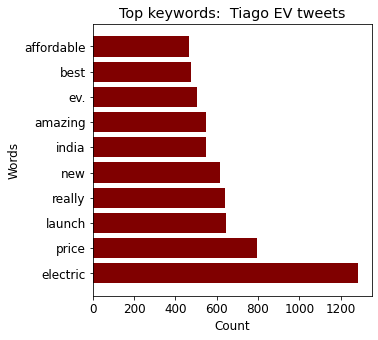

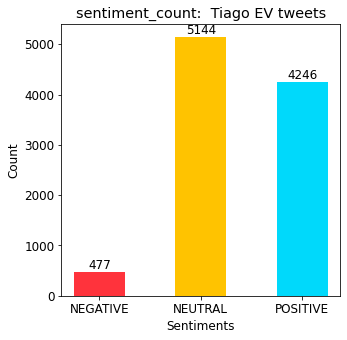

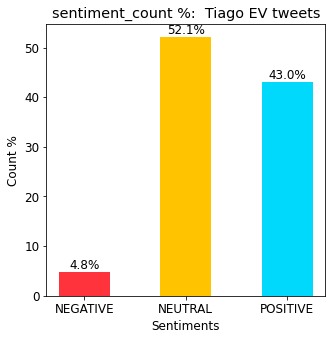

Total no of topics:  7
Top topics-->

Topic 1: ['motor' 'day' 'mais' 'become' 'punch' 'um' 'right' 'do' 'future' 'meu']


Topic 2: ['el' 'tomorrow' 'go' 'cars' 'la' 'amp' 'th' 'open' 'accessible' 'pr']


Topic 3: ['campina' 'licao' 'ससत' 'इलकटर' 'मत' 'रज' 'கக' 'el' 'pb' 'पर']


Topic 4: ['campina' 'licao' 'ससत' 'इलकटर' 'मत' 'रज' 'கக' 'pb' 'पर' 'नच']


Topic 5: ['el' 'tomorrow' 'go' 'cars' 'la' 'amp' 'open' 'accessible' 'th' 'pr']

Printing similar keywords ...
Keyword: electric, Related words: ['co' 'great' 'well' 'video' 'people' 'expected' 'control' 'month'
 'grande' 'cng']
Keyword: price, Related words: ['tatamotorsev' 'features' 'tatamotors_cars' 'wonderful' 'sale' 'diwali'
 'time' 'launched' 'motor' 'new']
Keyword: launch, Related words: ['so' 'well' 'se' 'suv' 'control' 'evs' 'nexon' 'altroz' 'segment'
 'automobile']
Keyword: really, Related words: ['four' 'delivery' 'set' 'showroom' 'every' 'country' 'friends' 'charging'
 'product' 'ex']
Keyword: new, Related words: ['tatamotors

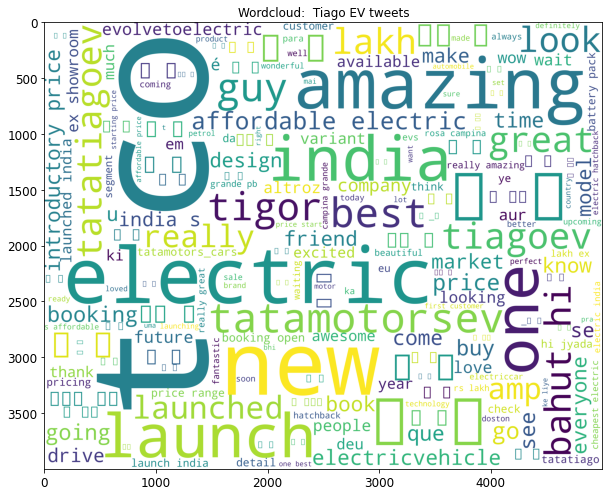

In [15]:
text_analysis(reviews_df,org=' Tiago EV tweets')